# Census API

In [1114]:
%matplotlib inline
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import data

In [1115]:
# API key
key = '8adabd93c8043a91d3a6bc40d4d48b01fdaa6c36'

#            0.    1.    2.    3.    4.    5.    6.
years =     [2015, 2016, 2017, 2018, 2019, 2020, 2021]
jsonData =  [None, None, None, None, None, None, None]
years_set = set(years)

### JSON data for 2015-2018 populations by state

In [1116]:
for i, year in enumerate(years[:4]):
    url = 'https://api.census.gov/data/{0}/pep/population?get=GEONAME,POP&for=state:*&key={1}'.format(year, key)
    response = requests.get(url)
    print(response)
    jsonData[i] = response.json()
    print("\t", end=" ")
    print(i, year)

<Response [200]>
	 0 2015
<Response [200]>
	 1 2016
<Response [200]>
	 2 2017
<Response [200]>
	 3 2018


### JSON data for 2019 populations by state

In [1117]:
url = 'https://api.census.gov/data/2019/pep/population?get=NAME,POP&for=state:*&key={0}'.format(key)
response = requests.get(url)
print(response, '2019')
jsonData[4] = response.json() # 2019 population

<Response [200]> 2019


### JSON data for 2020 populations by state

In [1118]:
url = 'https://api.census.gov/data/2021/pep/population?get=NAME,POP_2020&for=state:*&key={0}'.format(key)
response = requests.get(url)
print(response, '2020')
jsonData[5] = response.json() # 2020 population

<Response [200]> 2020


### JSON data for 2021 populations by state

In [1119]:
url = 'https://api.census.gov/data/2021/pep/population?get=NAME,POP_2021&for=state:*'.format(key)
response = requests.get(url)
print(response, '2021')
jsonData[6] = response.json() # 2021 population

<Response [200]> 2021


## Initialize data into DataFrames

In [1120]:
pop_data = {
    2015: None,
    2016: None,
    2017: None,
    2018: None,
    2019: None,
    2020: None,
    2021: None,
}

In [1121]:
for i, year in enumerate(years):
    pop_data[year] = pd.DataFrame(jsonData[i][1:], columns=jsonData[0][0])#.sort_values(by='GEONAME', ascending=True)
    if year == 2015:
        for i, state in enumerate(pop_data[year]['GEONAME'].str.split(',')):
            pop_data[year].iloc[i]['GEONAME'] = state[0]

In [1122]:
# Sort DataFrames by alphabetical order of state names and set index to state column (FIPS code)
for y in years:
    pop_data[y].sort_values(by='GEONAME', ascending=True, inplace=True)
    pop_data[y].set_index('state', inplace=True)

### Combine all population data into one master table

In [1123]:
pop_data_all = pd.DataFrame()
pop_data_all['GEONAME'] = pop_data[2015]['GEONAME']

In [1124]:
for y in years:
    pop_data_all['POP_{}'.format(y)] = pop_data[y]['POP']
    
    # Change data type to int
    pop_data_all['POP_{}'.format(y)] = pop_data_all['POP_{}'.format(y)].astype(int)

### Create a master table for population changes between years

In [1125]:
pop_data_change = pd.DataFrame()
pop_data_change['GEONAME'] = pop_data_all['GEONAME']

In [1126]:
for y in years[1:]:
    curr_year_pop = pop_data_all['POP_{}'.format(y)]
    prev_year_pop = pop_data_all['POP_{}'.format(y-1)]
    change = curr_year_pop - prev_year_pop
                                     
    pop_data_change['POP_CHANGE_FROM_{}_TO_{}'.format(y-1, y)] = change

### Create a table capturing population change by percent between years

In [1127]:
pop_data_percent = pd.DataFrame()
pop_data_percent['GEONAME'] = pop_data_all['GEONAME']

In [1128]:
for y in years[1:]:
    curr_year_pop = pop_data_all['POP_{}'.format(y)]
    prev_year_pop = pop_data_all['POP_{}'.format(y-1)]
    change = curr_year_pop - prev_year_pop
    percent = change / prev_year_pop
                                     
    pop_data_percent['POP_%_CHANGE_FROM_{}_TO_{}'.format(y-1, y)] = percent

In [1129]:
# Calculate percent change between two years
y1 = 2015
y2 = 2021
state = 'Arkansas'

###

calculate_years = [y1, y2]
calculate_years.sort()

y1_pop = pd.to_numeric(pop_data_all[pop_data_all['GEONAME']==state]['POP_{}'.format(calculate_years[0])])[0]
y2_pop = pd.to_numeric(pop_data_all[pop_data_all['GEONAME']==state]['POP_{}'.format(calculate_years[1])])[0]

s = pd.Series([y1_pop, y2_pop])
change = y2_pop - y1_pop
percent = change / y1_pop

print("Percent change: {:.4f}%".format(percent * 100), ('increase' if change >= 0 else 'decrease'))

Percent change: 1.6012% increase


## Visualizations

### Population graph

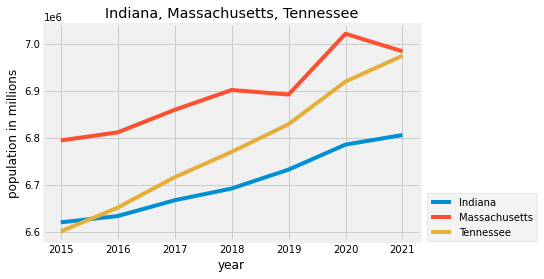

In [1130]:
# Graph population of a specific state by specified years

# states = ['New Jersey']
# states = ['California']
# states = ['Texas', 'Florida']
# states = ['Florida', 'New York']
# states = ['Pennsylvania', 'Illinois', 'Ohio']
# states = ['Ohio', 'Georgia', 'North Carolina']
# states = ['Georgia', 'North Carolina', 'Michigan']
# states = ['New Jersey', 'Virginia']
# states = ['Washington', 'Arizona']
states = ['Massachusetts', 'Tennessee', 'Indiana']
# states = ['Massachusetts', 'Tennessee', 'Indiana', 'Missouri', 'Maryland']
# states = ['Missouri', 'Maryland']
# states = ['Wisconsin', 'Colorado', 'Minnesota', 'South Carolina', 'Alabama']
# states = ['Louisiana', 'Kentucky', 'Oregon', 'Oklahoma']
# states = ['Connecticut', 'Utah', 'Puerto Rico', 'Iowa', 'Nevada', 'Arkansas', 'Mississippi', 'Kansas']
# states = ['New Mexico', 'Nebraska', 'Idaho', 'West Virginia']
# states = ['Hawaii', 'New Hampshire', 'Maine', 'Montana', 'Rhode Island', 'Delaware']
# states = ['South Dakota', 'North Dakota', 'Alaska', 'District of Columbia', 'Vermont', 'Wyoming']
graph_years = {2015, 2016, 2017, 2018, 2019, 2020, 2021} # see only these years in the graph

###

states.sort()
graph_years = list(years_set.intersection(graph_years))
graph_years.sort()

plt.xticks(graph_years)
plt.xlabel("year")
plt.ylabel("population in millions")

p = [0] * len(graph_years)

for i, state in enumerate(states):
    ref = pop_data_all[pop_data_all['GEONAME']==state].transpose().values[1:len(graph_years) + 1]
    for j, year in enumerate(graph_years):
        p[j] = ref[j][0]

    p_s = pd.Series(p, graph_years)
    p_s.plot(label=state)

plt.title(', '.join(states))
plt.legend(loc=(1.02, 0));

### Population pie chart

In [1137]:
top_states = 10 # The pie chart includes this many top states by population
reverse = False # Set to true to capture bottom x states (least population)
by_year = 2015 # The pie chart uses population data from this year

1. Create temporary DataFrame to capture top x states
1. Population of states not included will be represented as "other" in pie chart

In [1138]:
top_states_data = pop_data_all[['GEONAME', 'POP_{}'.format(by_year)]]
top_states_data = top_states_data.sort_values(by='POP_{}'.format(by_year), ascending=reverse).head(top_states)

other_pop = pd.to_numeric(pop_data_all['POP_{}'.format(by_year)][top_states:]).sum()

states = top_states_data['GEONAME']
slices = top_states_data['POP_{}'.format(by_year)]

states = states.append(pd.Series('other'))
slices = slices.append(pd.Series(other_pop))

Generate pie chart

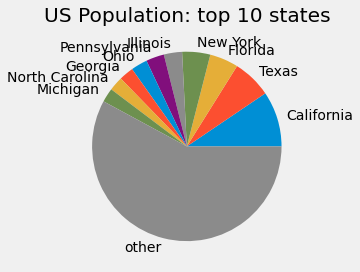

In [1139]:
plt.style.use("fivethirtyeight")
plt.pie(slices, labels=states, textprops={'fontsize': 14})
plt.title("US Population: top {} states".format(top_states))
plt.tight_layout()